# CS 418 Fall 2025 — Final Project Report (Team 4)

**Repo:** https://github.com/cs418-fa25/project-check-in-team-4#  
**Course:** CS 418 – Introduction to Data Science – Fall 2025  
**Team:** Team 4 (Zeehan, Colin, Maria, Michael, Jennifer)
**Project Title:** World Cup 2026 Outcome Forecasting

---

## 1. Project Introduction

**Core question:**  
Which national teams are most likely to advance through each knockout round of the 2026 FIFA Men’s World Cup, and who is most likely to win the tournament?

**What we are building:**  
- A reproducible pipeline that goes through raw data -> cleaned data -> engineered features -> predictive model -> (later) tournament simulation.
- A match-level model that outputs P(win / draw / loss) for one team vs another.
- A simulation framework (planned) that will use those match probabilities to estimate advancement odds by round (Round of 32, Round of 16, QF, SF, Final, Champion).

**Data so far:**  
We are using the Fjelstul World Cup csv, which contains every men’s World Cup match from 1930–2022, including the teams, scores, match stage, and date. The dataset is explicitly intended for research and predictive modeling and is available as CSV. We have downloaded and loaded this data locally.

---

## 2. Changes in Scope Since Our Proposal

**Original goal (proposal):**  
“Predict who wins the 2026 World Cup.”

**Updated scope (current):**
- Still predict the champion.
- Also estimate the probability that each team survives each knockout stage.
- Explicitly model match-level win/draw/loss probabilities instead of just declaring one favorite.

**Important:**  
- We have *not* finished the full tournament simulation (the Monte Carlo bracket for 2026). That is planned work for the second half of the semester. At mid-semester we are focused on data ingestion, feature engineering, and a first predictive model.
- We have not looked into more datasets yet, that is planned but is more of a reach goal. As of now, the datasets used for the model will be the Fjelstul World Cup CSVs. This can change if there is more time.
---

## 3. Data Cleaning

In [17]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
import os



sys.path.append(os.path.abspath(".."))
from src.cleaning import clean_matches
sys.path.append("../src") 


In [18]:
# data
goals = pd.read_csv("../data/raw/goals.csv")
player_app = pd.read_csv("../data/raw/player_appearances.csv")
players = pd.read_csv("../data/raw/players.csv")
team_app = pd.read_csv("../data/raw/team_appearances.csv")
group_standings = pd.read_csv("../data/raw/group_standings.csv")
tourney_standings = pd.read_csv("../data/raw/tournament_standings.csv")
penalty_kicks = pd.read_csv("../data/raw/penalty_kicks.csv")
teams = pd.read_csv("../data/raw/teams.csv")
# cleaning of matches via cleaning.py
matches_clean = clean_matches()
# adding referees + managers
refs = pd.read_csv("../data/raw/referee_appearances.csv")
mangaers = pd.read_csv("../data/raw/manager_appearances.csv")

In [19]:
#cleaning data for datasets not cleaned in cleaning.py

# checking for nulls/na's
print("Total for goals:", goals.isna().sum().sum())
print("Total for players_app:", player_app.isna().sum().sum())
print("Total for players:", players.isna().sum().sum())
print("Total for teams:", teams.isna().sum().sum())
print("Total for team_app:", team_app.isna().sum().sum())
print("Total for group_standings", group_standings.isna().sum().sum())
print("Total for tourney_standings:", tourney_standings.isna().sum().sum())
print("Total for penalty_kicks:", penalty_kicks.isna().sum().sum())
print("Total for referees:", refs.isna().sum().sum())
print("Total for managers:", mangaers.isna().sum().sum())

# filling the NA's/Nulls
players['birth_date'] = players['birth_date'].fillna('Unknown')
print("After removing NAs from players:", players.isna().sum().sum())

# removing women's data - only care about men's FIFA World Cup
men_goals = goals[~goals["tournament_name"].str.contains("Women")]
men_player_app = player_app[~player_app["tournament_name"].str.contains("Women")]
men_players = players[players["female"] == False]
men_group_standings = group_standings[~group_standings["tournament_name"].str.contains("Women")]
men_tourney_standings = tourney_standings[~tourney_standings["tournament_name"].str.contains("Women")]
men_penalty_kicks = penalty_kicks[~penalty_kicks["tournament_name"].str.contains("Women")]

# cleaning data further - after teammate made cleaning.py for matches
matches_clean = matches_clean[~matches_clean["tournament_name"].str.contains("Women")]
teams = teams.drop(columns=["womens_team", "mens_team_wikipedia_link" , "womens_team_wikipedia_link" , "federation_wikipedia_link"], axis=1)

# cleaned datasets
display(matches_clean.head(5))
display(men_goals.head(5))
display(men_player_app.head(5))
display(men_players.head(5))
display(team_app.head(5))
display(teams.head(5))
display(tourney_standings.head(5))
display(penalty_kicks.head(5))

Total for goals: 0
Total for players_app: 0
Total for players: 1
Total for teams: 0
Total for team_app: 0
Total for group_standings 0
Total for tourney_standings: 0
Total for penalty_kicks: 0
Total for referees: 0
Total for managers: 0
After removing NAs from players: 0


,key_id,tournament_id,tournament_name,match_id,match_name,stage,group,group_stage,knockout_stage,replayed,...,score_penalties,home_team_score_penalties,away_team_score_penalties,result,home_team_win,away_team_win,draw,year,goal_diff_home,match_result_1x2
0,1,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,group stage,Group 1,1,0,0,...,0-0,0,0,home team win,1,0,0,1930,3,win
1,2,WC-1930,1930 FIFA Men's World Cup,M-1930-02,United States vs Belgium,group stage,Group 4,1,0,0,...,0-0,0,0,home team win,1,0,0,1930,3,win
3,4,WC-1930,1930 FIFA Men's World Cup,M-1930-04,Romania vs Peru,group stage,Group 3,1,0,0,...,0-0,0,0,home team win,1,0,0,1930,2,win
4,5,WC-1930,1930 FIFA Men's World Cup,M-1930-05,Argentina vs France,group stage,Group 1,1,0,0,...,0-0,0,0,home team win,1,0,0,1930,1,win
5,6,WC-1930,1930 FIFA Men's World Cup,M-1930-06,Chile vs Mexico,group stage,Group 1,1,0,0,...,0-0,0,0,home team win,1,0,0,1930,3,win


,key_id,goal_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,...,shirt_number,player_team_id,player_team_name,player_team_code,minute_label,minute_regulation,minute_stoppage,match_period,own_goal,penalty
0,1,G-0001,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,1930-07-13,group stage,Group 1,T-30,...,0,T-30,France,FRA,19',19,0,first half,0,0
1,2,G-0002,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,1930-07-13,group stage,Group 1,T-30,...,0,T-30,France,FRA,40',40,0,first half,0,0
2,3,G-0003,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,1930-07-13,group stage,Group 1,T-30,...,0,T-30,France,FRA,43',43,0,first half,0,0
3,4,G-0004,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,1930-07-13,group stage,Group 1,T-46,...,0,T-46,Mexico,MEX,70',70,0,second half,0,0
4,5,G-0005,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,1930-07-13,group stage,Group 1,T-30,...,0,T-30,France,FRA,87',87,0,second half,0,0


,key_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,...,home_team,away_team,player_id,family_name,given_name,shirt_number,position_name,position_code,starter,substitute
0,1,WC-1970,1970 FIFA Men's World Cup,M-1970-01,Mexico vs Soviet Union,1970-05-31,group stage,Group 1,T-46,Mexico,...,1,0,P-66980,Calderón,Ignacio,1,goal keeper,GK,1,0
1,2,WC-1970,1970 FIFA Men's World Cup,M-1970-01,Mexico vs Soviet Union,1970-05-31,group stage,Group 1,T-46,Mexico,...,1,0,P-64553,Peña,Gustavo,3,defender,DF,1,0
2,3,WC-1970,1970 FIFA Men's World Cup,M-1970-01,Mexico vs Soviet Union,1970-05-31,group stage,Group 1,T-46,Mexico,...,1,0,P-42664,Pérez,Mario,5,defender,DF,1,0
3,4,WC-1970,1970 FIFA Men's World Cup,M-1970-01,Mexico vs Soviet Union,1970-05-31,group stage,Group 1,T-46,Mexico,...,1,0,P-69898,Hernández,Guillermo,6,midfielder,MF,1,0
4,5,WC-1970,1970 FIFA Men's World Cup,M-1970-01,Mexico vs Soviet Union,1970-05-31,group stage,Group 1,T-46,Mexico,...,1,0,P-56971,Salgado,Horacio López,10,forward,FW,1,0


,key_id,player_id,family_name,given_name,birth_date,female,goal_keeper,defender,midfielder,forward,count_tournaments,list_tournaments,player_wikipedia_link
0,1,P-35894,A'Court,Alan,1934-09-30,0,0,0,0,1,1,1958,https://en.wikipedia.org/wiki/Alan_A%27Court
2,3,P-03484,Aaronson,Brenden,2000-10-22,0,0,0,0,1,1,2022,https://en.wikipedia.org/wiki/Brenden_Aaronson
3,4,P-04189,Abadzhiev,Stefan,1934-07-03,0,0,0,0,1,1,1966,https://en.wikipedia.org/wiki/Stefan_Abadzhiev
4,5,P-03523,Abalo,Jean-Paul,1975-06-26,0,0,1,0,0,1,2006,https://en.wikipedia.org/wiki/Jean-Paul_Abalo
6,7,P-35138,Abanda,Patrice,1978-08-03,0,0,1,0,0,1,1998,https://en.wikipedia.org/wiki/Patrice_Abanda


,key_id,tournament_id,tournament_name,match_id,match_name,stage_name,group_name,group_stage,knockout_stage,replayed,...,goals_against,goal_differential,extra_time,penalty_shootout,penalties_for,penalties_against,result,win,lose,draw
0,1,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,group stage,Group 1,1,0,0,...,1,3,0,0,0,0,win,1,0,0
1,2,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,group stage,Group 1,1,0,0,...,4,-3,0,0,0,0,lose,0,1,0
2,3,WC-1930,1930 FIFA Men's World Cup,M-1930-02,United States vs Belgium,group stage,Group 4,1,0,0,...,0,3,0,0,0,0,win,1,0,0
3,4,WC-1930,1930 FIFA Men's World Cup,M-1930-02,United States vs Belgium,group stage,Group 4,1,0,0,...,3,-3,0,0,0,0,lose,0,1,0
4,5,WC-1930,1930 FIFA Men's World Cup,M-1930-03,Yugoslavia vs Brazil,group stage,Group 2,1,0,0,...,1,1,0,0,0,0,win,1,0,0


,key_id,team_id,team_name,team_code,mens_team,federation_name,region_name,confederation_id,confederation_name,confederation_code
0,1,T-01,Algeria,DZA,1,Algerian Football Federation,Africa,CF-2,Confederation of African Football,CAF
1,2,T-02,Angola,AGO,1,Angolan Football Federation,Africa,CF-2,Confederation of African Football,CAF
2,3,T-03,Argentina,ARG,1,Argentine Football Association,South America,CF-4,South American Football Confederation,CONMEBOL
3,4,T-04,Australia,AUS,1,Football Australia,Oceania,CF-1,Asian Football Confederation,AFC
4,5,T-05,Austria,AUT,1,Austrian Football Association,Europe,CF-6,Union of European Football Associations,UEFA


,key_id,tournament_id,tournament_name,position,team_id,team_name,team_code
0,1,WC-1930,1930 FIFA Men's World Cup,1,T-84,Uruguay,URY
1,2,WC-1930,1930 FIFA Men's World Cup,2,T-03,Argentina,ARG
2,3,WC-1930,1930 FIFA Men's World Cup,3,T-83,United States,USA
3,4,WC-1930,1930 FIFA Men's World Cup,4,T-87,Yugoslavia,YUG
4,5,WC-1934,1934 FIFA Men's World Cup,1,T-41,Italy,ITA


,key_id,penalty_kick_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name,given_name,shirt_number,converted
0,1,PK-001,WC-1982,1982 FIFA Men's World Cup,M-1982-50,West Germany vs France,1982-07-08,semi-finals,not applicable,T-86,West Germany,DEU,1,0,P-68969,Kaltz,Manfred,20,1
1,2,PK-002,WC-1982,1982 FIFA Men's World Cup,M-1982-50,West Germany vs France,1982-07-08,semi-finals,not applicable,T-86,West Germany,DEU,1,0,P-48686,Breitner,Paul,3,1
2,3,PK-003,WC-1982,1982 FIFA Men's World Cup,M-1982-50,West Germany vs France,1982-07-08,semi-finals,not applicable,T-86,West Germany,DEU,1,0,P-45695,Stielike,Uli,15,0
3,4,PK-004,WC-1982,1982 FIFA Men's World Cup,M-1982-50,West Germany vs France,1982-07-08,semi-finals,not applicable,T-86,West Germany,DEU,1,0,P-89975,Littbarski,Pierre,7,1
4,5,PK-005,WC-1982,1982 FIFA Men's World Cup,M-1982-50,West Germany vs France,1982-07-08,semi-finals,not applicable,T-86,West Germany,DEU,1,0,P-59574,Rummenigge,Karl-Heinz,11,1


---
## 4. EDA

The data we are working with holds match information and during which world cup these matches took place in to be able to connect matches and countries to their respective tournaments.  
  
Something we believe is that data from the early world cups may not be as reliable as many countries have been able to develop their own national soccer team over the century leading to better competition.  
  
Here is what our data looks like:

In [20]:
display(matches_clean.head(1))
display(men_goals.head(1))
display(men_player_app.head(1))
display(men_players.head(1))
display(team_app.head(1))
display(teams.head(1))
display(tourney_standings.head(1))
display(penalty_kicks.head(1))

,key_id,tournament_id,tournament_name,match_id,match_name,stage,group,group_stage,knockout_stage,replayed,...,score_penalties,home_team_score_penalties,away_team_score_penalties,result,home_team_win,away_team_win,draw,year,goal_diff_home,match_result_1x2
0,1,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,group stage,Group 1,1,0,0,...,0-0,0,0,home team win,1,0,0,1930,3,win


,key_id,goal_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,...,shirt_number,player_team_id,player_team_name,player_team_code,minute_label,minute_regulation,minute_stoppage,match_period,own_goal,penalty
0,1,G-0001,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,1930-07-13,group stage,Group 1,T-30,...,0,T-30,France,FRA,19',19,0,first half,0,0


,key_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,...,home_team,away_team,player_id,family_name,given_name,shirt_number,position_name,position_code,starter,substitute
0,1,WC-1970,1970 FIFA Men's World Cup,M-1970-01,Mexico vs Soviet Union,1970-05-31,group stage,Group 1,T-46,Mexico,...,1,0,P-66980,Calderón,Ignacio,1,goal keeper,GK,1,0


,key_id,player_id,family_name,given_name,birth_date,female,goal_keeper,defender,midfielder,forward,count_tournaments,list_tournaments,player_wikipedia_link
0,1,P-35894,A'Court,Alan,1934-09-30,0,0,0,0,1,1,1958,https://en.wikipedia.org/wiki/Alan_A%27Court


,key_id,tournament_id,tournament_name,match_id,match_name,stage_name,group_name,group_stage,knockout_stage,replayed,...,goals_against,goal_differential,extra_time,penalty_shootout,penalties_for,penalties_against,result,win,lose,draw
0,1,WC-1930,1930 FIFA Men's World Cup,M-1930-01,France vs Mexico,group stage,Group 1,1,0,0,...,1,3,0,0,0,0,win,1,0,0


,key_id,team_id,team_name,team_code,mens_team,federation_name,region_name,confederation_id,confederation_name,confederation_code
0,1,T-01,Algeria,DZA,1,Algerian Football Federation,Africa,CF-2,Confederation of African Football,CAF


,key_id,tournament_id,tournament_name,position,team_id,team_name,team_code
0,1,WC-1930,1930 FIFA Men's World Cup,1,T-84,Uruguay,URY


,key_id,penalty_kick_id,tournament_id,tournament_name,match_id,match_name,match_date,stage_name,group_name,team_id,team_name,team_code,home_team,away_team,player_id,family_name,given_name,shirt_number,converted
0,1,PK-001,WC-1982,1982 FIFA Men's World Cup,M-1982-50,West Germany vs France,1982-07-08,semi-finals,not applicable,T-86,West Germany,DEU,1,0,P-68969,Kaltz,Manfred,20,1


## Interesting EDA charts
### European and South American teams dominate the World Cup stage.
The chart shows that UEFA (Europe) has by far the most World Cup wins, with almost 500 victories total. CONMEBOL (South America) comes next with around 200 wins. The other regions have much fewer wins overall. This shows how World Cup success has mostly stayed within Europe and South America over the years.

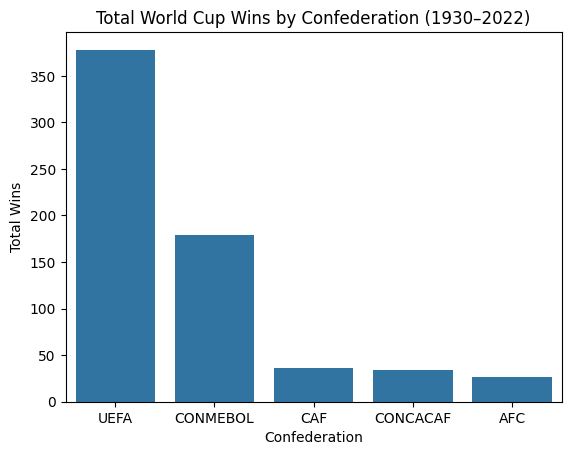

In [21]:
wins_only_home = matches_clean[matches_clean["home_team_win"] == 1]
wins_only_away = matches_clean[matches_clean["away_team_win"] == 1]

home_counts = wins_only_home["home_team_name"].value_counts().reset_index()
home_counts.columns = ["team_name", "home_wins"]

away_counts = wins_only_away["away_team_name"].value_counts().reset_index()
away_counts.columns = ["team_name", "away_wins"]

win_totals = pd.merge(home_counts, away_counts, on="team_name", how="outer").fillna(0)
win_totals["total_wins"] = win_totals["home_wins"] + win_totals["away_wins"]
merged_wins = pd.merge(win_totals, teams[["team_name", "confederation_name"]], on="team_name", how="left")
wins_by_conf = merged_wins.groupby("confederation_name")["total_wins"].sum().reset_index().sort_values(by="total_wins", ascending=False)
# for label naming purposes
conf_map = {
    "Union of European Football Associations": "UEFA",
    "South American Football Confederation": "CONMEBOL",
    "Confederation of African Football": "CAF",
    "Confederation of North, Central American and Caribbean Association Football": "CONCACAF",
    "Asian Football Confederation": "AFC"
}
wins_by_conf["confederation_name"] = wins_by_conf["confederation_name"].map(conf_map)
sns.barplot(data=wins_by_conf, x="confederation_name", y="total_wins")
plt.title("Total World Cup Wins by Confederation (1930–2022)")
plt.xlabel("Confederation")
plt.ylabel("Total Wins")
plt.show()

### Goal-scoring peaked in early tournaments and has steadily dropped.

Average goals per match were extremely high in the early World Cups, often above 4–5 goals per game, but dropped sharply after the 1950s as new tactics, defensive structures, and professional coaching rose. From the 1970s onward, the scoring rate stabilizes around 2.3–2.8 goals per match, showing a long-term trend toward more balanced and strategic play rather than wide-open scoring.

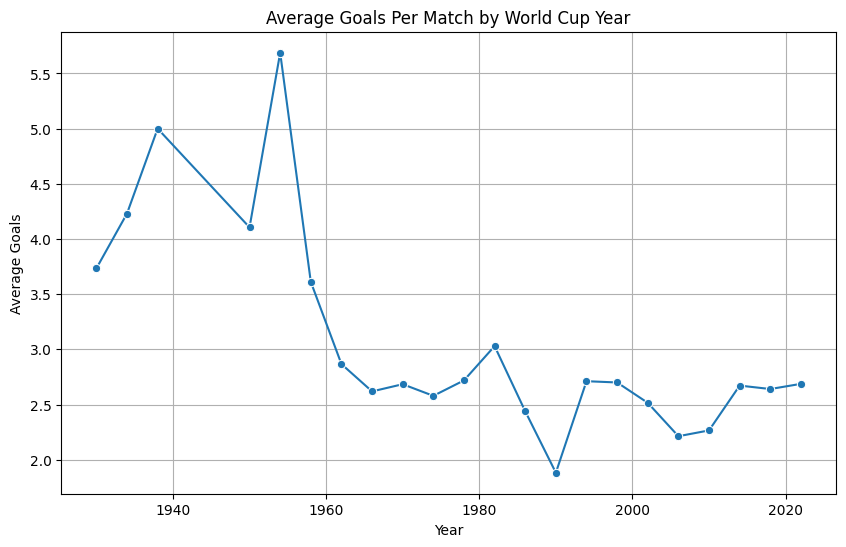

In [22]:
goals_matches = matches_clean
goals_matches['total_goals'] = goals_matches['score_home'] + goals_matches['score_away']
goals_per_year = goals_matches.groupby('year').agg(avg_goals=('total_goals', 'mean'), matches=('match_id', 'count')).reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=goals_per_year, x='year', y='avg_goals', marker='o')
plt.title("Average Goals Per Match by World Cup Year")
plt.xlabel("Year")
plt.ylabel("Average Goals")
plt.grid(True)
plt.show()

---
## 5. Visualization and Hypothesis Ideas

## Hypothesis: Historically successful nations are predicted to show consistently higher win counts across all recorded World Cup tournaments.
### Why its important?:
We chose to test whether past World Cup success correlates with sustained dominance across decades. Identifying consistently strong nations can help the model capture long-term team quality factors that ELO alone may not explain.
### Interpretaion: Brazil has scored the most wins overall in all World Cup tournaments played
Brazil leads all nations with nearly 80 total World Cup matches' wins, followed by Argentina, Italy, France, and Germany. However, West Germany also appears separately within the top five, despite representing the same nation today. This indicates that further consideration and data cleaning are needed, as historical country distinctions like this could affect the accuracy of the predictive model.

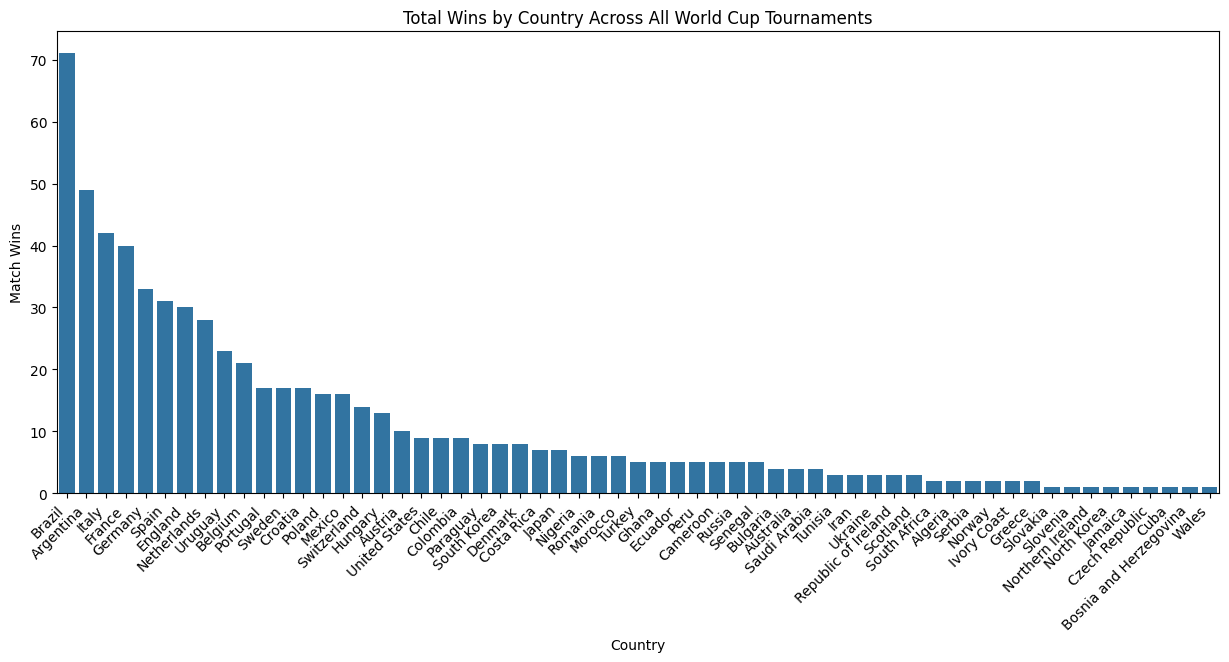

In [23]:
wins_only_home = matches_clean[matches_clean["home_team_win"] == 1]
wins_only_away = matches_clean[matches_clean["away_team_win"] == 1]

home_counts = wins_only_home["home_team_name"].value_counts().reset_index()
home_counts.columns = ["team_name", "home_wins"]

away_counts = wins_only_away["away_team_name"].value_counts().reset_index()
away_counts.columns = ["team_name", "away_wins"]

win_totals = pd.merge(home_counts, away_counts, on="team_name", how="outer").fillna(0)
win_totals["total_wins"] = win_totals["home_wins"] + win_totals["away_wins"]
win_totals = win_totals.sort_values(by="total_wins", ascending=False)

plt.figure(figsize=(15,6))
sns.barplot(win_totals, x="team_name", y="total_wins")
plt.title(label="Total Wins by Country Across All World Cup Tournaments")
plt.xlabel("Country")
plt.ylabel("Match Wins")
plt.xticks(rotation=45, ha="right")
plt.show()

--- 
## 6. prediction/dependant varibale on your dataset

The calculated elo for each team is the most important stat that we use in determining outcomes of matches, the elo of a team is a calculation for reletive skill of players and teams.
The elo is calculated by the following variables
match results in previous world cups, 
elo results from previous years,
differences in goal amounts, and percentages, between teams,
and field advantage.

In the future we plan to add additional variables to our calculations, some of those may include coach changes, team composition changes, and aging of team members effecting overall team performance. 

---
## Feature Engineering - Exploration of features

In [24]:
new_matches = matches_clean.copy()
pen_match_ids = penalty_kicks['match_id'].unique()

# penalties
new_matches['went_to_penalties'] = new_matches['match_id'].isin(pen_match_ids).astype(int)

# players in match
exp = men_player_app.groupby('match_id').agg(players_in_match=('player_id', 'count')).reset_index()

merged = new_matches.merge(exp, on='match_id', how='left')
merged['players_in_match'] = merged['players_in_match'].fillna(0).astype(int)

# avg age
apps = men_player_app.merge(players[['player_id', 'birth_date']],on='player_id',how='left')
apps = apps.merge(
    matches_clean[['match_id', 'date']],
    on='match_id',
    how='left'
)
apps['birth_date'] = pd.to_datetime(apps['birth_date'], errors='coerce')
apps['date'] = pd.to_datetime(apps['date'], errors='coerce')
apps['player_age'] = (apps['date'] - apps['birth_date']).dt.days / 365.25
avg_age = apps.groupby('match_id').agg(avg_age=('player_age', 'mean')).reset_index()
merged = merged.merge(avg_age, on='match_id', how='left')
merged['avg_age'] = merged['avg_age'].fillna(0)

# encoding
label_map = {"win": 1, "draw": 0, "loss": -1}
merged['match_label'] = merged['match_result_1x2'].map(label_map)

# correlation matrix
corr_df = merged[['went_to_penalties', 'players_in_match', 'avg_age', 'match_label']]
corr_matrix = corr_df.corr()
corr_matrix


,went_to_penalties,players_in_match,avg_age,match_label
went_to_penalties,1.000000,0.111986,0.092760,-0.041295
players_in_match,0.111986,1.000000,0.985797,-0.302745
avg_age,0.092760,0.985797,1.000000,-0.302310
match_label,-0.041295,-0.302745,-0.302310,1.000000


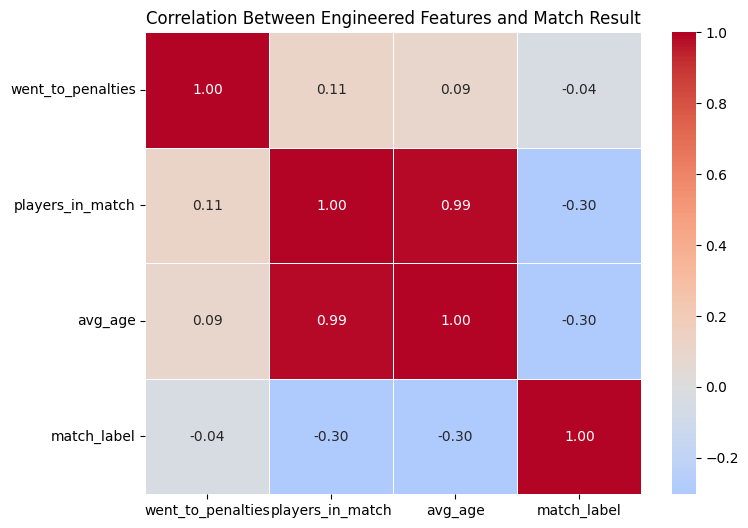

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm',center=0, linewidths=.5,fmt=".2f")
plt.title("Correlation Between Engineered Features and Match Result")
plt.show()

The heatmap shows that players_in_match and avg_age are almost perfectly correlated (0.99), meaning they capture essentially the same information about teams. Both features show a slight negative correlation (-0.32) with match outcomes, suggesting that matches involving more players and older squads tend to be associated with draws or losses rather than wins. Meanwhile, went_to_penalties has almost no correlation with match outcome (-0.03), indicating it should not be used as a predictive feature in the final model.

---
## Further Data Cleaning for Model

In [26]:
out_teams = ["Czechoslovakia","Yugoslavia", "Soviet Union", "USSR", "Zaire", "Dutch East Indies", "Serbia and Montenegro", "Bohemia", "United Arab Republic","East Germany", "Northern Rhodesia", "Rhodesia","Republic of China"]
model_ready = matches_clean[~matches_clean['home_team_name'].isin(out_teams) & ~matches_clean['away_team_name'].isin(out_teams)]


---
## 7. Reflection

**What is the hardest part of the project that you've encountered so far?**

The hardest part about this project we have encountered so far would be finding a good data source. Originally, when we were searching for our sources we encountered many data sources that was about the FIFA game and not the actual World Cup. Another is getting revelant data and getting the data for how the teams and players have changed over time. New players may have joined the team or players that have had an injury can affect results. Overall, the challenge was refining our data to take these factors into consideration.

**What are your intial insights?**

Our initial insight is that we have found top 10 teams in the tournament by comparing their elo ratings. We have another insight that previous winners are also expected to perform other teams.

**Are there any concrete results you can show at this point? If not, why not?**

No, we have not because we need the machine learning to predict who will win the tournaments. All we can do now is look at the top 10 and we cannot make concrete guesses based on this data.

**Going forward, what are the current biggest problems you're facing?**

Currently, the biggest problem is needing to figure out a way to combine the data of the players and their injuries and also new players.

**Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?**

We have enough data, but we realize we need to dedicate more time on the machine learning aspect. 

**Given your intial exploration of the data, is it worth proceeding with your project, why? If not, how are you going to change your project and why do you think it's better than your current results?**

We think it's still worth to continue our project with the same questions and data.


---
## 8. Roles/Coordination


project roles:  
**cleaning:** (Zeehan, Maria, Colin)  
**machine learning:** (Zeehan, Jennifer, Maria)  
**statistical analysis:** (Michael, Jennifer)  
**data source scouting:** (Colin, Michael, Maria, Jennifer)   
**visualization:** (Maria, Michael)  
**quality control and consistancy checking:** (Colin, Maria)  
**testing:** (Maria, Jennifer, Zeehan, Colin, Michael)  


---
 ## 9. Next Steps



 In our next steps, we will be working on refining our rudimentry machine learning model. We will work on increasing overall accuracy. We will test our program by testing our predicted results of recent world cup results to the actual real life results. In these tests we will only train our predictive models on data from before the world cup we are testing against. 

 expand our data set, involving more data on players, coaches, and referees, to incorperate more variables that may affect future matches. 

 Finally, We will focus on testing these new variables in our predictions against our current data. We will need to learn more about machine learning in order to best integrate our code with a machine learning model. Hopefully the next few weeks of class will help us will dealing with refining our models. 